## Problem Set 6
## MACS 40000

In [19]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [20]:
df_main = pd.read_stata('p13i6.dta')
df_summ = pd.read_stata('rscfp2013.dta')
df = pd.concat([df_main, df_summ], axis = 1)

In [21]:
# Keep the variables and observations that we need
df = df[['X5804', 'X5809', 'X5814', 'X5805', 'X5810', 'X5815', 'X8022', 'networth', 'wgt']]

In [22]:
# Replace the bequests received before 2011 by 0 and multiply by inflation index 
df.loc[df.X5805 < 2011, 'X5804'] = 0
df.loc[df.X5810 < 2011, 'X5809'] = 0
df.loc[df.X5815 < 2011, 'X5814'] = 0

df.loc[df.X5805 == 2011, 'X5804'] = 0.9652 * df.loc[df.X5805 == 2011, 'X5804']
df.loc[df.X5805 == 2012, 'X5804'] = 0.9854 * df.loc[df.X5805 == 2012, 'X5804']
df.loc[df.X5810 == 2011, 'X5809'] = 0.9652 * df.loc[df.X5810 == 2011, 'X5809']
df.loc[df.X5810 == 2012, 'X5809'] = 0.9854 * df.loc[df.X5810 == 2012, 'X5809']
df.loc[df.X5815 == 2011, 'X5814'] = 0.9652 * df.loc[df.X5805 == 2011, 'X5814']
df.loc[df.X5815 == 2012, 'X5814'] = 0.9854 * df.loc[df.X5805 == 2012, 'X5814']

In [23]:
# Multiply by weight
df[['X5804', 'X5809', 'X5814']].multiply(df['wgt'], axis="index")

# Calculate age at which bequests are received
df['age_1'] = df['X8022'] - (2013 - df['X5805'])
df['age_2'] = df['X8022'] - (2013 - df['X5810'])
df['age_3'] = df['X8022'] - (2013 - df['X5815'])
df.loc[df.age_1 < 21, 'X5804'] = 0
df.loc[df.age_2 < 21, 'X5809'] = 0
df.loc[df.age_2 < 21, 'X5814'] = 0

In [24]:
# Calculate total bequests by age
bq_tot = np.zeros(80)
for i in range(21, 101):
    bq_tot[i - 21] = df.loc[df['X8022'] == i, 'X5804'].sum() + df.loc[df['X8022'] == i, 'X5809'].sum() + \
                       df.loc[df['X8022'] == i, 'X5814'].sum()
bq_tot /= bq_tot.sum()

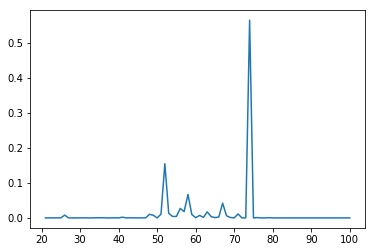

In [25]:
plt.plot(np.arange(21, 101), bq_tot)
plt.show()